In [2]:
import pandas as pd
import numpy as np
import re
import os
from PyRuSH import RuSH
import PyRuSH
# default rule file location
rule_file=os.path.join(os.path.dirname(os.path.dirname(PyRuSH.__file__)),'conf/rush_rules.tsv')
rush = RuSH(rule_file)

from transformers import AutoTokenizer, AutoConfig

data_folder = "/PHShome/cs1839/capstone_data/"
llm_folder = "/PHShome/jn180/llm_public_host"

/netapp2/home/cs1839/miniforge3/envs/pyrush/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# Preprocess Internal Data 

In [13]:
# get all sheet names in the PPV file
sheet_names = pd.read_excel(data_folder + "PPV.xlsx", sheet_name=None).keys()

def filter_PPV_match(input_df):
    input_df = input_df[input_df['PPV'].notnull()]
    return input_df[input_df['PPV'] == 1]

# read sheets('samples-ppv-random', 'samples-ppv-stop', 'samples-ppv-take') in with PPV is 1
samples_ppv_random = pd.read_excel(data_folder + "PPV.xlsx", sheet_name='samples-ppv-random')
samples_ppv_random = filter_PPV_match(samples_ppv_random)


samples_ppv_stop = pd.read_excel(data_folder + "PPV.xlsx", sheet_name='samples-ppv-stop')
samples_ppv_stop = filter_PPV_match(samples_ppv_stop)


samples_ppv_take = pd.read_excel(data_folder + "PPV.xlsx", sheet_name='samples-ppv-take')
samples_ppv_take = filter_PPV_match(samples_ppv_take)

print("samples-ppv-random:", samples_ppv_random.shape)
print("samples-ppv-stop:", samples_ppv_stop.shape)
print("samples-ppv-take:", samples_ppv_take.shape)

samples-ppv-random: (96, 8)
samples-ppv-stop: (93, 8)
samples-ppv-take: (97, 6)


In [14]:
# Function to extract sentences around the target snippet based on regex match indices
def extract_surrounding_sentences(row):
    # Determine whether to use SelectedTaking or SelectedStopTaking based on the 'Taking' value
    if row['Taking'] == 1:
        target_info = row.get('SelectedTaking', None)  # Safely get SelectedTaking if it exists
    else:
        target_info = row.get('SelectedPriorStop', None)  # Safely get SelectedStopTaking if it exists
        if target_info is None or target_info is np.nan:
            target_info = row.get('SelectedStopTaking', None)
            pattern = re.compile(r"match='([^']*)'")
            match = pattern.search(target_info)
            if match:
                target_info = match.group(1)
            else:
                target_info = None

    note_txt = row['NoteTXT']
    # remove leading and trailing whitespaces
    target_info = target_info.strip() if target_info else None

    # Ensure that target_info is a string
    if isinstance(target_info, str):
        if row['Taking'] == 1:
            # Use regex to extract the span (start and end index) for SelectedTaking
            match = re.search(r"span=\((\d+),\s*(\d+)\)", target_info)
            
            if match:
                start, end = map(int, match.groups())  # Extract and convert the indices to integers
            else:
                return None  # No span match found

        else:
            # For SelectedPriorStop, locate the exact position of target_info in the note text
            start = note_txt.find(target_info)
            if start == -1:
                return None  # target_info not found in NoteTXT
            end = start + len(target_info)

        # Extract the target snippet
        target_snippet = note_txt[start:end]
        
        # Use RuSH to segment the entire note into sentences
        sentences = rush.segToSentenceSpans(note_txt)

        # Find the sentence that contains the start of the target snippet
        target_sentence_idx = -1
        for i, sentence in enumerate(sentences):
            if sentence.begin <= start < sentence.end:
                target_sentence_idx = i
                break

        if target_sentence_idx == -1:
            return None  # No sentence contains the target snippet
        
        # Extract 2 sentences, 1 before and 1 sentences after the target snippet
        start_idx = max(0, target_sentence_idx - 1)
        end_idx = min(len(sentences), target_sentence_idx + 1)  # +2 to include 1 after the target

        # Join and return the surrounding sentences
        surrounding_sentences = " ".join([note_txt[sentence.begin:sentence.end] for sentence in sentences[start_idx:end_idx]])
        return surrounding_sentences
    else:
        return None
  
# Apply the function to the all dfs in [samples_ppv_random, samples_ppv_stop, samples_ppv_take]
samples_ppv_random['snippet'] = samples_ppv_random.apply(extract_surrounding_sentences, axis=1)
## removed a row because not able to locate the snippet in the note
samples_ppv_random = samples_ppv_random.dropna(subset=['snippet'])

samples_ppv_stop['snippet'] = samples_ppv_stop.apply(extract_surrounding_sentences, axis=1)
samples_ppv_take['snippet'] = samples_ppv_take.apply(extract_surrounding_sentences, axis=1)

# # # save the dfs in different sheet of one csv file
# with pd.ExcelWriter(data_folder + "PPV_snippet.xlsx") as writer:
#     samples_ppv_random.to_excel(writer, sheet_name='samples-ppv-random', index=False)
#     samples_ppv_stop.to_excel(writer, sheet_name='samples-ppv-stop', index=False)
#     samples_ppv_take.to_excel(writer, sheet_name='samples-ppv-take', index=False)



## Medication Extraction and Formatting



In [32]:
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
# List of already known medications (example list)
known_medications = {
    'prochlorperazine', 'compazine', 'navane', 'fluphenazine', 'haldol', 
    'haloperidol', 'pimozide', 'stelazine', 'thorazine',
    'prolixin', 'perphenazine', 'sertraline', 'memantine',
    'chlorpromazine', 'loxapine'
}


def extract_medications(matched_str):
    # Define a pattern to capture medication names (capitalized words or fully uppercase ones    
    word_pattern = r'\b[A-Za-z0-9-]+\b'
    
    # Find all capitalized words (potential medication names)
    potential_medications = re.findall(word_pattern, matched_str)
    potential_medications = [word.lower() for word in potential_medications]
    # if there are compund words, also store a split verison
    potential_medications.extend([word_split for word in potential_medications for word_split in word.split('-') if len(word_split) > 1])
    # Get the set of English stopwords from nltk
    nltk_stop_words = set(stopwords.words('english'))

    # Add domain-specific stop words that are not medications
    custom_stop_words = {'Take', 'TAKE', 'MG', 'PO', 'Qam', 'QHS', 'mg', 'tablet', 'dose', 'this', 'these', 'Instructions', 'received'}
    # convert to lower cases
    custom_stop_words = {word.lower() for word in custom_stop_words}

    # Combine nltk stop words with custom stop words
    all_stop_words = nltk_stop_words.union(custom_stop_words)
    
    # Strip any trailing punctuation and filter out stop words (lowercase comparison)
    filtered_medications = [word.strip('.,()').lower() for word in potential_medications if word.lower() not in all_stop_words]
    filtered_medications = set(filtered_medications)
    
    # # Compare with the known medications list (case-insensitive)
    valid_medications = [med for med in filtered_medications if med in known_medications]
    # print('match string:', potential_medications)
    # print(f"Potential medications: {filtered_medications}")
    # print(f"Valid medications: {valid_medications}")
    return valid_medications

def extract_match_string(regex_match_str):
    # Define a regex pattern to extract the content between 'match=' and the closing '>'
    pattern = r"match='([^']*)'"  # This will capture everything between 'match=' and the closing '>'
    
    # Search the pattern in the provided string
    match = re.search(pattern, regex_match_str)
    
    # If a match is found, return the captured group, otherwise return None
    if match:
        # Extract the matched string (medication details with instructions)
        matched_str = match.group(1)
        return matched_str
    else:
        return None

# extract the active_medications
taking_regex_match = pd.DataFrame(pd.concat([samples_ppv_random[samples_ppv_random.Taking==1], samples_ppv_take]))
taking_regex_match['match'] = taking_regex_match['SelectedTaking'].apply(extract_match_string)
taking_regex_match['active_medications'] = taking_regex_match['match'].apply(extract_medications)
taking_regex_match['discontinued_medications'] = None
# set all entries of discontinued_medications to a empty list
taking_regex_match['discontinued_medications'] = taking_regex_match['discontinued_medications'].apply(lambda x: [])
taking_regex_match.drop(columns=['match'], inplace=True)

# extract the discontinued_medications
stop_taking_regex_match = pd.DataFrame(pd.concat([samples_ppv_random[samples_ppv_random.Taking==0], samples_ppv_stop]))
# if SelectedPriorStop is nan, copy snippet to SelectedPriorStop
stop_taking_regex_match['SelectedPriorStop'] = stop_taking_regex_match['SelectedPriorStop'].fillna(stop_taking_regex_match['snippet'])
stop_taking_regex_match['active_medications'] = None
stop_taking_regex_match['active_medications'] = stop_taking_regex_match['active_medications'].apply(lambda x: [])
stop_taking_regex_match['discontinued_medications'] = stop_taking_regex_match['SelectedPriorStop'].apply(extract_medications)

# go through the snippets and go over the known medications to active_medications convered all in known medications if they are in the snippets
def check_all_med(row):
    mentioned_list = []
    for med in known_medications:
        med = med.lower()
        if med in str(row['snippet']).lower():
            mentioned_list.append(med)
    return mentioned_list

taking_regex_match['active_medications'] = taking_regex_match.apply(check_all_med, axis=1)
stop_taking_regex_match['discontinued_medications'] = stop_taking_regex_match.apply(check_all_med, axis=1)

combined = pd.concat([taking_regex_match, stop_taking_regex_match])
combined.drop_duplicates(subset=['snippet'], inplace=True)

# get the length of snippet in the combined df
combined['snippet_len'] = combined['snippet'].apply(lambda x: len(x.split(' ')))
# fulter our active_medications and discontinued_medications that are empty
combined = combined[combined['active_medications'].apply(lambda x: len(x) > 0) | combined['discontinued_medications'].apply(lambda x: len(x) > 0)]

# combined[['snippet', 'active_medications', 'discontinued_medications']].to_csv(data_folder + "PPV_snippet_medications.csv", index=False)

In [5]:
data = pd.read_csv(data_folder + "PPV_snippet_medications.csv")

# randomly sample 5 lines to be dev set
dev = data.sample(5, random_state=1)
# get the rest removing dev lines
data = data.drop(dev.index)
data.to_csv(data_folder + "PPV_snippet_medications.csv", index=False)
dev.to_csv(data_folder + "PPV_snippet_medications_dev.csv", index=False)


# Preprocess MIMIC-IV

In [2]:

import seaborn as sns
import pandas as pd
import numpy as np
from ast import literal_eval

data_folder = "/PHShome/cs1839/capstone_data/"
# data_df = pd.read_csv(data_folder + "PPV_snippet_medications.csv")
data_df = pd.read_csv(data_folder + 'mimic_iv_snippets.csv')
# turn back active_medications and discontinued_medications to list
data_df['active_medications'] = data_df['active_medications'].apply(lambda x: [y.strip().lower() for y in x.split(',')] if x is not np.nan else [])
data_df['discontinued_medications'] = data_df['discontinued_medications'].apply(lambda x: [y.strip().lower() for y in x.split(',')] if x is not np.nan else [])
data_df['neither_medications'] = data_df['neither_medications'].apply(lambda x: [y.strip().lower() for y in x.split(',')] if x is not np.nan else [])
# data_df.to_csv(data_folder + 'mimic_iv_snippets_list.csv', index=False)

data_df2 = pd.read_excel(data_folder + 'mimic_iv_snippets_set2.xlsx', engine='openpyxl')[:100]
data_df2['active_medications'] = data_df2['active_medications'].apply(lambda x: [y.strip().lower() for y in x.split(',') if y.strip()] if x is not np.nan else [])
data_df2['discontinued_medications'] = data_df2['discontinued_medications'].apply(lambda x: [y.strip().lower() for y in x.split(',')  if y.strip()] if x is not np.nan else [])
data_df2['neither_medications'] = data_df2['neither_medications'].apply(lambda x: [y.strip().lower() for y in x.split(',')  if y.strip()] if x is not np.nan else [])

df = pd.concat([data_df, data_df2]).drop_duplicates(subset=['snippet'])
# df.to_csv(data_folder + 'mimic_iv_snippets_list_new.csv', index=False)

# Max Length (all snippets can fit)


In [3]:
# get the longest length of the column NoteTXT in all sheets
# A list of potential tokenizers and get the longest length of the tokenized words
# from meta-llama-Meta-Llama-3.1-8B, facebook-opt-125m, BioMistral-7B, Qwen2.5-7B-Instruct, gemma-2-27b-it
# report:
# longest word_length
# the corresponding token amount using the different tokenizers

# List of model paths in your local environment
name_model_paths ={   
    # "Bio_ClinicalBERT": "/PHShome/jn180/llm_public_host/Bio_ClinicalBERT",

    "Llama-3.1-8B": "/netapp3/raw_data3/share/llm_public_host/Llama-3.1-8B",
    "Llama-3.1-8B-Instruct": "/netapp3/raw_data3/share/llm_public_host/Llama-3.1-8B-Instruct",
    "Llama-3.2-3B-Instruct": "/netapp3/raw_data3/share/llm_public_host/Llama-3.2-3B-Instruct",

    "Qwen2-7B-Instruct": "/PHShome/jn180/llm_public_host/Qwen2-7B-Instruct",
    "Qwen2.5-14B-Instruct": "/netapp3/raw_data3/share/llm_public_host/Qwen2.5-14B-Instruct",

    "meditron-7b": "/PHShome/jn180/llm_public_host/meditron-7b",

    "Mistral-Large-Instruct-2407": "/netapp3/raw_data3/share/llm_public_host/Mistral-Large-Instruct-2407",
    "Mistral-Nemo-Instruct-2407": "/netapp3/raw_data3/share/llm_public_host/Mistral-Nemo-Instruct-2407",
}

tokenizers = {}

# Load each tokenizer and model config to get the max input token limit
tokenizer_limits = {}

for model_name, model_path in name_model_paths.items():
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    tokenizers[model_name] = tokenizer
    
    # Load config to get max input token limit
    config = AutoConfig.from_pretrained(model_path)
    max_token_limit = getattr(config, 'max_position_embeddings', None)
    
    if max_token_limit is not None:
        tokenizer_limits[model_name] = max_token_limit
    else:
        # If max_position_embeddings is not available in config, fall back to a default (or warn)
        tokenizer_limits[model_name] = 'Unknown'

# Combine all 'NoteTXT' columns
all_notes = pd.read_csv(data_folder + "PPV_snippet_medications.csv")['snippet'].tolist()

# Find the longest note (in terms of word length)
longest_note = max(all_notes, key=lambda x: len(x.split() if isinstance(x, str) else ''))
longest_word_length = len(longest_note.split())

print(f"Longest note word count: {longest_word_length}")
print(f"Longest note content: \n{longest_note}")

# Tokenize the longest note using each tokenizer and compare with the model token limits
token_lengths = {}
for model_name, tokenizer in tokenizers.items():
    tokenized = tokenizer(longest_note, return_tensors="pt")
    token_length = tokenized.input_ids.shape[1]
    token_limit = tokenizer_limits.get(model_name, 'Unknown')
    
    exceeds_limit = False if token_limit == 'Unknown' else token_length > token_limit
    token_lengths[model_name] = {
        "token_count": token_length,
        "token_limit": token_limit,
        "exceeds_limit": exceeds_limit
    }

# Print tokenization details
for model_name, details in token_lengths.items():
    print(f"\n{model_name}:")
    print(f"  Token count: {details['token_count']}")
    print(f"  Token limit: {details['token_limit']}")
    print(f"  Exceeds limit: {details['exceeds_limit']}")


Longest note word count: 534
Longest note content: 
NOVOLIN INSULIN 70/30 (INSULIN 70/30 HUMAN) 70-30/ML VIAL; Dose: Not available; Form: Not available; Route: SC; Frequency: Not available; Directions: Not available; Details: Dispense: ML(s); Taking; Status: Active; Source: ALLAM,GREGORY J.,M.D.; Date: 11/11/2013 Indications: Type 2 Diabetes Mellitus   • [DISCONTINUED] metFORMIN (GLUCOPHAGE) 500 MG tablet METFORMIN 500 MG TABLET; Dose: Not available; Form: Not available; Route: PO; Frequency: Not available; Directions: Not available; Details: Dispense: Tablet(s); Taking; Status: Active; Source: ALLAM,GREGORY J.,M.D.; Date: 11/11/2013   • [DISCONTINUED] nystatin (NYSTOP) powder NYSTATIN POWDER 100000/G POWDER; Dose: Not available; Form: Not available; Route: TOP; Frequency: Not available; Directions: Not available; Details: Dispense: Gram(s); Status: Active; Source: REED,DANIELLE; Date: 11/11/2013   • [DISCONTINUED] nystatin-triamcinolone cream NYSTATIN/TRIAMCINOLONE 100000-0.1 CREAM (G

In [41]:
import tiktoken
import json

# Define your model; change this based on the specific GPT model you are using
model_name = "gpt-4o"  # Options: 'gpt-4', 'gpt-3.5-turbo', etc.

# Initialize the tokenizer for the chosen model
encoding = tiktoken.encoding_for_model(model_name)

# Your text input
# load prompts.json and read Other_5_shots_CoT
with open('prompts.json') as f:
    prompts = json.load(f)

prompt = prompts['Other_5_shots_CoT']
mimic_df = pd.read_csv(data_folder + 'mimic_iv_snippets_list_new.csv')
# get the longest snippet in mimic_df
longest_snippet_mimic = max(mimic_df['snippet'], key=lambda x: len(x.split()))
text = prompt.format(longest_snippet_mimic)

# Tokenize the text
tokens = encoding.encode(text)

# Get the number of tokens
num_tokens = len(tokens)

# Output the result
print(f"The text contains {num_tokens} tokens.")

The text contains 1288 tokens.


# EDA

## number of distinct medications

In [1]:
# 1. Number of items (i.e. number of input)
# 2. Average number of words of the input (the original EHR text, not include prompt)
# 3. Number of medications to be extracted (for task 1)
# 4. Number of discontinued medication
# 5. Number of active medication
# 6. Number of neither medication
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, AutoConfig

data_folder = "/PHShome/cs1839/capstone_data/"
llm_folder = "/PHShome/jn180/llm_public_host"

data_set_names = ['PPV_snippet_medications.csv', 'mimic_iv_snippets_list_new.csv', 'medication_status_test.csv']

def dataset_characteristics(dataset, data_folder):
    # check if this is PPV dataset
    if dataset == 'PPV_snippet_medications.csv':
        dataset_name = 'Internal'
    elif dataset == 'mimic_iv_snippets_list_new.csv':
        dataset_name = 'MIMIC-IV'
    else:
        dataset_name = 'MIT'

    # Load the dataset
    data_df = pd.read_csv(data_folder + dataset)

    # Get the number of items
    num_items = data_df.shape[0]

    # Get the average number of words in the input
    avg_num_words = data_df['snippet'].apply(lambda x: len(x.split())).mean()

    # Get the number of medications to be extracted
    num_active = data_df['active_medications'].apply(len).sum()

    # Get the number of discontinued medications using set to 
    num_discontinued = data_df['discontinued_medications'].apply(len).sum()

    # Get the number of neither medications
    num_neither = data_df['neither_medications'].apply(len).sum() if 'neither_medications' in data_df.columns else 0

    # Number of medications to be extracted
    num_medications = num_active + num_discontinued
    num_medications = num_medications + num_neither if num_neither > 0 else num_medications

    # print everything 
    print("\n")
    print(f"Dataset: {dataset_name}")
    print(f"Number of items: {num_items}")
    print(f"Average number of words: {avg_num_words:.2f}")
    print(f"Number of medications to be extracted: {num_medications}")
    print(f"Number of active medications: {num_active}")
    print(f"Number of discontinued medications: {num_discontinued}")
    print(f"Number of neither medications: {num_neither}")


for dataset in data_set_names:
    dataset_characteristics(dataset, data_folder)



Dataset: Internal
Number of items: 241
Average number of words: 90.93
Number of medications to be extracted: 7389
Number of active medications: 5269
Number of discontinued medications: 2120
Number of neither medications: 0


Dataset: MIMIC-IV
Number of items: 299
Average number of words: 67.55
Number of medications to be extracted: 12092
Number of active medications: 8491
Number of discontinued medications: 2539
Number of neither medications: 1062


Dataset: MIT
Number of items: 100
Average number of words: 62.61
Number of medications to be extracted: 4475
Number of active medications: 2384
Number of discontinued medications: 1499
Number of neither medications: 592


In [ ]:
known_medications = {'prochlorperazine', 'compazine', 'navane', 'fluphenazine', 'haldol', 
                     'haloperidol', 'pimozide','STELAZINE','THORAZINE',
                     'prolixin', 'perphenazine', 'sertraline', 'memantine',
                     'chlorproMAZINE', 'loxapine'} 

## distribution of medications mentioned

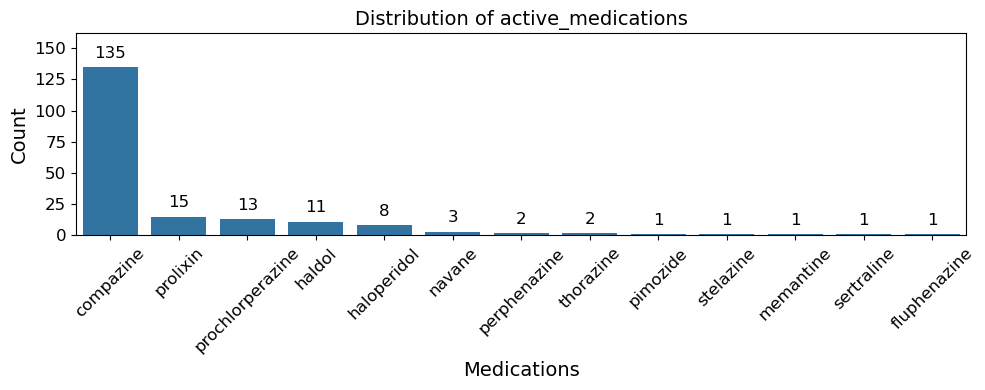

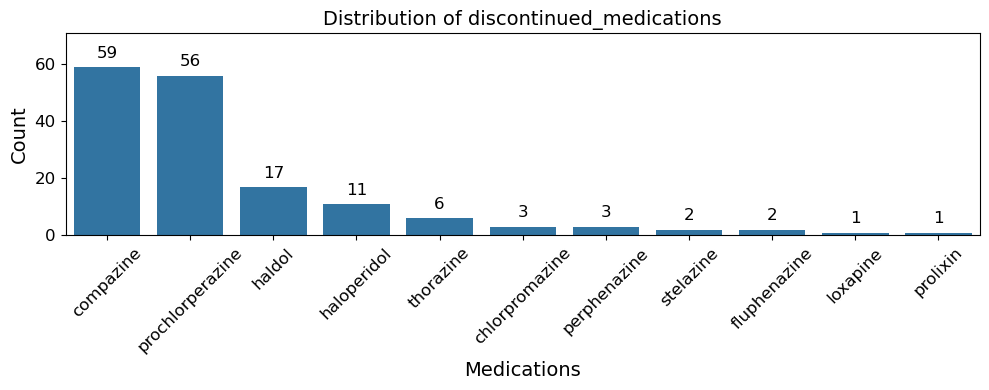

In [93]:
def draw_distribution(data_df, column_name):

    medication_counts = data_df[column_name].explode().value_counts()

    # Convert the medication counts to a dictionary
    medication_dict = medication_counts.to_dict()

    # Create a bar plot using Seaborn
    plt.figure(figsize=(10, 4))
    ax = sns.barplot(x=list(medication_dict.keys()), y=list(medication_dict.values()))

    # Add labels and title
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f'Distribution of {column_name}', fontsize=14)
    plt.xlabel('Medications', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    # Annotate each bar with its count
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height() ), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points', fontsize=12)
        
    # Adjust the y-limit to give space above the bars and make the bars smaller
    ax.set_ylim(0, max(medication_dict.values()) * 1.2)  # Add some extra space above the tallest bar

    # Show the plot
    plt.tight_layout()
    plt.show()

draw_distribution(data_df, 'active_medications')
draw_distribution(data_df, 'discontinued_medications')

## length distribution of snippets

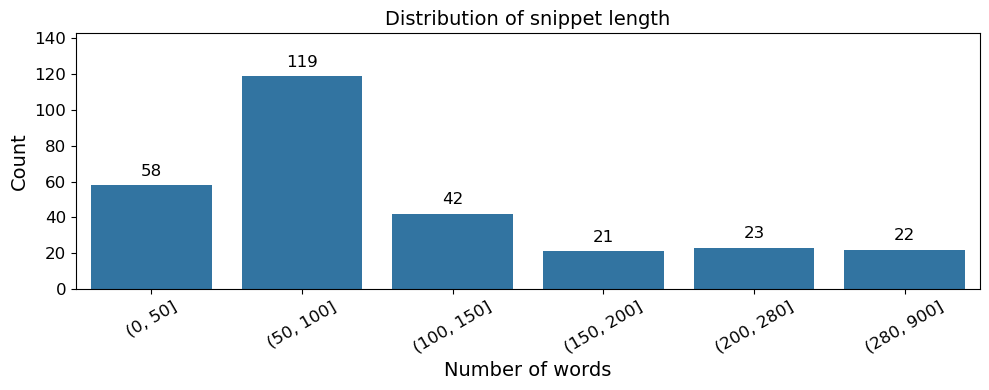

In [99]:
data_df['snippet_length'] = data_df['snippet'].apply(lambda x: len(x.split()))
# cut the snippet_length into 10 bins and make sure all start and end are integers
data_df['snippet_length_bins'] = pd.cut(data_df['snippet_length'], bins=10, precision=0)
# can u expand the fist bin to a granular level
data_df['snippet_length_bins'] = pd.cut(data_df['snippet_length'], bins=[0, 50, 100, 150, 200, 280, 900], precision=0)
counts = data_df['snippet_length_bins'].explode().value_counts().sort_index()

# Convert the medication counts to a dictionary
len_dict = counts.to_dict()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 4))
ax = sns.barplot(x=list(len_dict.keys()), y=list(len_dict.values()))

# Add labels and title
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Distribution of snippet length', fontsize=14)
plt.xlabel('Number of words', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height() ), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points', fontsize=12)

# Adjust the y-limit to give space above the bars and make the bars smaller
ax.set_ylim(0, max(len_dict.values()) * 1.2)  # Add some extra space above the tallest bar

# Show the plot
plt.tight_layout()
plt.show()